# Phase 2

By Asher Lipman, Cianna Chairez, Allie Pultorak, and Carrie Kim  

## Research Questions

Our research project seeks to investigate the role that villains play in classical-style mystery "whodunit" movies throughout the 20th and early 21st centuries. While their existence and importance within this genre are without debate, there hasn't been much analysis regarding the structural role they play in these movies, how they differ from other characters besides "they get caught in the end", or how they might share similar characteristics even across movies. Specifically, we desire to explore the three questions below: 

- How does the time period during which the movie was released have an impact on how villains in archetypally typical mystery movies are portrayed (how they speak and act)? 

- Do villains have patterns of speech or content they bring up that are noticably different from other characters in their films? (for example: Do patterns of word/phrase usage emerge? Are villains routinely portraying a certain sentiment or showing feelings of guilt?)

- As a combination of both of those questions, how do the two aspects discussed here interact with each other? Do the patterns of villain behavior identified in movies change over time?

- Do villains more closely resemble villains from other movies or their supporting cast in the same movie. In other words, is there something unique about villains that overcomes the stylistic similarity to other characters in their movies.



## Data Collection and Cleaning

Our raw text files existed scattered across a series of folders delineated by genre (examples included "Crime", "Action", "Comedy", etc.). In order to just work with the movies which met our "classical mystery" classification, we grouped all the movies we'd identified into a separate "Using" folder. At this point we had our movie scripts and our movie metadata files, which are stored in the drama_movies, crime_movies, and thriller_movies python files. These metadata files are an intermediate stage, but they're desribed in more detail in the dataset creation section. We then took the below steps in order to turn those text files into a workable dataset. 

First, we load the necessary libaries and metadata dictionaries, as well as create our spacy nlp object for later use

In [1]:
#will install spacy and necessary dataset if you do not have it already on your computer

##!conda install -c conda-forge spacy spacy-lookups-data -y
##!python -m spacy download en_core_web_lg

In [2]:
#import necessary libraries
import os
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import re
import spacy

#import the three libraries of assembled movie metdata
from collections import defaultdict
from drama_movies import drama_movies
from crime_film_noir import crime_movies
from thriller_movies import thriller_movies

In [3]:
nlp=spacy.load("en_core_web_lg")

Then we created a set of convenience functions. This first one checks to see if a new line in a moviescript indicates a new character

In [4]:
#Checks to see if a given line follows the same format as a new character tag
def check_if_character(line, punct_set):
    if "(" in line:
        line=line[:line.index("(")].strip()
    if "{" in line:
        line=line[:line.index("{")].strip()
    if '[' in line:
        line=line[:line.index('[')].strip()
    if "/" in line:
            line=line[:line.index('/')-1].strip()
    if line.upper()==line and line.isupper() and line[-1] not in punct_set and line.count(' ')<4:
        
        return True, line
    else:
        return False, ""


This convenience function checks to see if the character that's currently being mentioned in the script is one of the characters we've previously identified as important, either for their own merit or for being the villain

In [5]:
#Checks to see if this character is either one of the important characters in the story or a villain
def check_if_acceptable_character(this_character, acceptable_characters):
    if this_character in acceptable_characters:
        return True
    else:
        cleaner=str.maketrans('','',string.punctuation)
        this_character=this_character.translate(cleaner)
        for character in acceptable_characters:
            if character in this_character or this_character in character:
                return True
    return False

        

This is the beefiest convenience function, the one which actually reads the movie scripts. Instead of using this to directly create a pandas dataframe, we instead decided to make it a standard list in order to make it easier to iterate through each character and remove them. While the exact specifications are described in the method, essentially it creates a list of all the characters from across all movies and includes their name, the movie title, the year the movie's from, their dialogue, and the number of words they had to say in a dedicated dictionary. 

In [6]:
"""takes the movie metadata, reads each script, and returns a list made of dictionaries corresponding to each new character that's been labeled as important. The list and dictionaries follow the format below

[{"character": "the name of the character", "movie_title": "the title of the movie they're in", "year" int(the year the movie came out), "raw_dialogue": "All the words they say in the movie", "num_words": int(the number of words they say in the movie)}]
"""
def read_scripts(movie_metadata, unacceptable_starters, punct_remover):

    returner=[]

    for movie_filename in movie_metadata:
        path=os.path.join("data", "scripts","Using", movie_filename)
        current_movie=movie_metadata[movie_filename]

        with open(path, "r", encoding="utf-8") as f:
            movie_script=f.readlines()
            start_of_content=False
            this_movie_dicts=[]
            current_character_dict={}
            movie_title=movie_metadata[movie_filename]['title']
            current_character_name="" 
            year=int(current_movie['year'])
            acceptable_characters=current_movie["characters"]+current_movie['villain']      
            
            for line in movie_script:
                line=line.strip()

                #checks for the title and the first character, otherwise skips the header stuff
                if not start_of_content:
                    line=line.strip('"')

                    is_character, new_character_name = check_if_character(line, string.punctuation)

                    if is_character and new_character_name not in unacceptable_starters and check_if_acceptable_character(new_character_name, acceptable_characters):
                        start_of_content=True
                        current_character_name=new_character_name
                        current_character_dict={"character": current_character_name, "movie_title": movie_title, "year":year, "is_villain": False, "raw_dialogue":""}
                        if current_character_name in current_movie['villain']:
                            current_character_dict['is_villain']=True
                        this_movie_dicts.append(current_character_dict)
                
                #if in the middle of the script and you have a current character, check if this line is a new character otherwise add the dialogue to this character's list
                else:
                    is_new_character, new_character_name = check_if_character(line, string.punctuation)
                    if is_new_character:
                        current_character_name=new_character_name
                        if current_character_name not in unacceptable_starters and check_if_acceptable_character(current_character_name, acceptable_characters):
                            if current_character_name not in [entry['character'] for entry in this_movie_dicts]:
                                current_character_dict={"character": current_character_name, "movie_title": movie_title, "year":year, "is_villain": False, "raw_dialogue":""}
                                if current_character_name in current_movie['villain']:
                                    current_character_dict['is_villain']=True
                                this_movie_dicts.append(current_character_dict)
                            else:
                                current_character_dict=[entry for entry in this_movie_dicts if entry['character']==current_character_name][0]
                            
                    else:
                        if current_character_name in unacceptable_starters or not check_if_acceptable_character(current_character_name, acceptable_characters):
                            pass
                        else:
                            if len(line)>0 and line[0]!='(' and line not in unacceptable_starters:
                                current_character_dict['raw_dialogue']=current_character_dict['raw_dialogue'].strip()+' ' + line.translate(punct_remover).strip()

            returner+=this_movie_dicts

        
    for entry in returner:
        entry['num_words']=entry['raw_dialogue'].count(' ')+1
    returner=[entry for entry in returner if entry['num_words']>50]    

    return returner                            
    

While the above code works for most script formats, occassionally formatting errors in the script itself can result in errors. Additionally often the same character will be referred to by different names in a script. For example, in a single movie dialogue spoken by the character Harry Wilkens might be labelled as Harry, Mr. Wilkens, Harry's Voice, or any other permutations. Additionally, while the original researchers claimed to have removed setting description and camera directions from the scripts, they did not do so entirely. These often appear in the same format in the script as calls for new characters, causing countless errors. These two convenience functions below serve to elimniate these errors. The first deals with the issue of character permutations, allowing us to combine all the dialogue said by two characters and then deleting the extras from the list. The second is more simple, and is used to flat-out remove entries that were not characters but were added in error.

In [7]:
#A convenience function that adds all lines from character_name_to_remove to character_name_to_keep and then removes character_name_to_remove from the list. 
def combine_characters(movie_character_dict, movie_title, character_name_to_keep, character_name_to_remove):
    movie_subset=[entry for entry in movie_character_dict if entry['movie_title']==movie_title]
    if character_name_to_remove not in [entry['character'] for entry in movie_subset] or character_name_to_keep not in [entry['character'] for entry in movie_subset]:
        return
    to_remove=[entry for entry in movie_character_dict if entry['character']==character_name_to_remove][0]
    keeper=[entry for entry in movie_subset if entry['character']==character_name_to_keep][0]
    keeper['raw_dialogue']+=to_remove['raw_dialogue']
    keeper['num_words']+=to_remove['num_words']
    movie_character_dict.remove(to_remove)

In [8]:
#removes the character with this character name from the list
def remove_character(movie_character_dicts, character):
    to_remove=[entry for entry in movie_character_dicts if entry['character']==character]
    if len(to_remove)!=0:
        movie_character_dicts.remove(to_remove[0])

The below function, given a pandas dataframe which includes a character's raw dialogue, will add a column including a list of all the tokens present in each character's dialogue that isn't punctuation, a space, or a commonly used filler or "stop" word

In [9]:
#given a dataframe and a spacy nlp object, adds a column to the dataframe with an array of tokens present in each dialogue entry that aren't spaces, punctuation, or common stop words
def tokenize(data_frame,nlp):
    data_frame['token_list']=[[token for token in nlp(doc) if not (token.is_punct or token.is_space or token.is_stop)] for doc in data_frame['raw_dialogue']]

The below function makes use of our second dataset, the NRC Word-Emotion Association Lexicon. Again, the specifics and sourcing of this lexicon are addressed more directly in our data collection section. However, in practice what this does is associate a set of given words with a set of ten sentiments: anger, anticipation, disgust, fear, joy negative, positive, sadness, surprise, trust. These associations are binary, if a word is associated with the sentiment it will have a score of 1, otherwise it will be 0. The below function runs through each of the tokens in a character's dialogue and calculates the average sentiment score for all of their words put togeher across the 10 sentiments.

In [9]:
#given a list of tokens, calculates a a mean emotional scoring of that list for each of the ten emotions present in the NRC Word-Emotion Association Emolex
def add_emotion_scores(token_list, lexicon=None):
    string_list=[token.text.lower().strip() for token in token_list]
    re=[[],[],[],[],[],[],[],[],[],[]]
    if lexicon==None:
        lexicon=read_emolex()
    for token in string_list:
        if token in lexicon:
            score_list=list(lexicon[token].values())
            for score_index in range(len(score_list)):
                re[score_index].append(score_list[score_index])
    re=[score if len(score)>0 else [0] for score in re]
    to_return = [np.mean(emotion) for emotion in re]
    return to_return
    

    

The below function simply reads the emolex into a python dictionary, it was actually provided by Professor Wilkens for a previous class (INFO 3350)

In [10]:
# Source: Professor Wilkens, INFO 3350
#convenience function to read the emotion lexicon into the variable emolex
def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = os.path.join('data','emolex.txt')
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data. Make sure you set the right file path above.
emolex = read_emolex()


Another important factor we wanted to take into account was that while the words characters use might differ dramatically, the actual content of what they're trying to say might align very well. Word2Vec embeddings are essentially 300dimensional representations of a given word, with words of similar meanings being located near each other in this high dimensional space. Below, we calculate for each word a character says that word's embedding (or where it lies in this 300 dimensional space). We then average out these word embeddings (the mean of each dimension) to create a single 300 dimensional point that represents the character's dialogue as a whole. 

In [11]:
#given a list of tokens, calculate the mean embedding for all token in the list
def add_embeddings(token_list, vector_length):
    token_list=[token for token in token_list if token.has_vector]
    doc_matrix=np.zeros([len(token_list), vector_length])
    for i in range(len(doc_matrix)):
        doc_matrix[i]=token_list[i].vector
    return np.average(doc_matrix, axis=0)

Here we start actually assembling our dataset. We start by loading in our three separate metadata dictionaries into a single variable called amalgamated_dicts. we then declare a series of terms we cite as being unacceptable character names (often camera directions or non-character narration) and then store our list of character entities into movie_character_dicts

In [12]:

amalgamated_dicts={}
amalgamated_dicts.update(drama_movies)
amalgamated_dicts.update(crime_movies)
amalgamated_dicts.update(thriller_movies)

unacceptable_starters=["VOICE (cont'd)", "VOICE (CONT'D)", "VOICE OVER (CONT'D)", "VOICE OVER (cont'd)", "DISSOLVE", "CUT", "CUT TO", 'FADE', 'FADE OUT', 'FADE IN', 'PAN', 'CONTINUED', "CONT'D", '', ' ', "VOICE", "VOICE OVER", 'CUT TO', 'DISSOLVE TO', 'THE END', 'FADE TO BLACK', "DISSOLVE TO:", "CUT TO:", "FADE TO:"]

punct_remover=str.maketrans('','', '"#$%&()*+-/:;<=>?@[\\]^_`{|}~')

movie_character_dicts=read_scripts(amalgamated_dicts, unacceptable_starters, punct_remover)

Below is a long list of miscalaneous fixes as described in the combine_characters and remove_character defintions

In [13]:
#random fixes

combine_characters(movie_character_dicts, "8MM", "AMY", "AMY'S VOICE")
combine_characters(movie_character_dicts, "8mm", "DINO VELVET", "DINO")
combine_characters(movie_character_dicts, "8mm", "DINO VELVET", "DINO VELVET VOICE")
combine_characters(movie_character_dicts, "8mm", "WELLES", "WELLES VOICE")
combine_characters(movie_character_dicts, "8mm", "WELLES", "WELLES' VOICE")
combine_characters(movie_character_dicts, "MANHATTAN MURDER MYSTERIES", "HELEN", "HELEN'S VOICE")
combine_characters(movie_character_dicts, 'The Black Dahlia', "CAPTAIN VASQUEZ", 'VASQUEZ')
combine_characters(movie_character_dicts, 'The Black Dahlia', "JOHNNY VOGEL", 'JOHNNY')
combine_characters(movie_character_dicts, 'The Black Dahlia', "JOHNNY VOGEL", 'VOGEL')
combine_characters(movie_character_dicts, "The Black Dahlia", "LEE BLANCHARD", "LEE")
combine_characters(movie_character_dicts, "The Black Dahlia", "Liz", "Elizabeth")
combine_characters(movie_character_dicts, 'The Black Dahlia', "ELLIS LOEW", 'LOEW')
combine_characters(movie_character_dicts, 'The Black Dahlia', "RUSS MILLARD", 'MILLARD')
combine_characters(movie_character_dicts, 'BASIC INSTINCT', "CAPTAIN TALCOTT", 'TALCOTT')
combine_characters(movie_character_dicts, 'BASIC INSTINCT', "CAPTAIN TALCOTT", 'CAPT. TALCOTT')
combine_characters(movie_character_dicts, 'Basic', "DUNBAR", 'DUN BAR')
combine_characters(movie_character_dicts, 'Basic', "MUELLER", 'MUE:LLER')
combine_characters(movie_character_dicts, 'Basic', "OSBORNE", 'OSB0RNE')
combine_characters(movie_character_dicts, 'The Girl With ', "GREGOR", 'GREGER')
combine_characters(movie_character_dicts, 'THE GIRL WITH THE DRAGON TATTOO', "GREGOR", 'GREGER')
combine_characters(movie_character_dicts, 'THE GIRL WITH THE DRAGON TATTOO', "BLOMKVIST", 'BLOMVIST')
combine_characters(movie_character_dicts, 'THE GIRL WITH THE DRAGON TATTOO', "HARRIET", 'HARRIE')
combine_characters(movie_character_dicts, 'THE GIRL WITH THE DRAGON TATTOO', "WENNERSTROM", 'WENNERSTROM ON TV')
combine_characters(movie_character_dicts, 'THE GIRL WITH THE DRAGON TATTOO', "VANGER", 'YOUNGER VANGER')
combine_characters(movie_character_dicts, 'Insomnia', 'WALTER', "WALTER'S VOICE")
combine_characters(movie_character_dicts, "Blood Simple", "MARTY", "MARTY'S VOICE")
combine_characters(movie_character_dicts, "Bonnie and Clyde", "BONNIE", "BONNIE'S VOICE")
combine_characters(movie_character_dicts, "Twin Peaks", "BOBBY", "BOB'S VOICE")
combine_characters(movie_character_dicts, "Klute", "TRASK", "TRASK'S VOICE")
combine_characters(movie_character_dicts, "Klute", "CABLE", "CABLE'S VOICE")
combine_characters(movie_character_dicts, "Brick", "LAURA", "LAURA'S VOICE")
combine_characters(movie_character_dicts, "Brick", "BRENDAN", "BRENDAN'S VOICE")
combine_characters(movie_character_dicts, "Charade", "REGGIE", "REGGIE'S VOICE")
combine_characters(movie_character_dicts, "Copycat", "DARYLL LEE", "DARYLL")
combine_characters(movie_character_dicts, "Sherlock Holmes", "SHERLOCK", "HOLMES")
combine_characters(movie_character_dicts, "Crank", "Verona", "Erona")
combine_characters(movie_character_dicts, "Blood Simple", "DOC MILES", "OC MILES")
combine_characters(movie_character_dicts, "Devil in a Blue Dress", "ALBRIGHT", "ALBRIGHT'S VOICE")
combine_characters(movie_character_dicts, "Blood Simple", "DAPHNE", "DAPHNE'S VOICE")
combine_characters(movie_character_dicts, "Anonymous", "ELIZABETH", "YOUNG ELIZABETH")
combine_characters(movie_character_dicts, "Anonymous", "OXFORD", "YOUNG OXFORD")
combine_characters(movie_character_dicts, "Anonymous", "ROBERT CECIL", "BOY ROBERT CECILDAPHNE'S VOICE")

remove_character(movie_character_dicts, "BONNY & CLYDE")
remove_character(movie_character_dicts,"I")
remove_character(movie_character_dicts, "GRAMAM'S FEET")
remove_character(movie_character_dicts, "HOLMES POV")
remove_character(movie_character_dicts, "MRS. MULWRAY")
remove_character(movie_character_dicts,"C")
remove_character(movie_character_dicts,"S")
remove_character(movie_character_dicts,"T")
remove_character(movie_character_dicts,"H")
remove_character(movie_character_dicts,"A")
remove_character(movie_character_dicts,"I")
remove_character(movie_character_dicts,"VE")
remove_character(movie_character_dicts,"C")
remove_character(movie_character_dicts,"DARKMAN")
remove_character(movie_character_dicts,"161 PEYTON 161")
remove_character(movie_character_dicts,"THE DARKMAN")
remove_character(movie_character_dicts,"421 DARKMAN 421")


We finally create a dataframe from our list of dictionaries here, stored in the local_dataframe variable. We then added columns for word tokens, average emotional scores, and dialogue embeddings as described above

In [14]:
local_dataframe=pd.DataFrame.from_dict(movie_character_dicts)

In [15]:
%%time
tokenize(local_dataframe, nlp)

Wall time: 1min 12s


In [16]:
%%time
all_emotions = [add_emotion_scores(entry) for entry in local_dataframe['token_list']]
local_dataframe['mean_anger'], local_dataframe['mean_anticipation'], local_dataframe['mean_disgust'], local_dataframe['mean_fear'], local_dataframe['mean_joy'], local_dataframe['mean_negative'], local_dataframe['mean_positive'], local_dataframe['mean_sadness'], local_dataframe['mean_surprise'], local_dataframe['mean_trust'] = np.flipud(np.rot90(all_emotions))

Wall time: 35.1 s


In [17]:
%%time
vector_length=nlp.vocab.vectors_length
local_dataframe['embeddings']=[add_embeddings(entry, vector_length) for entry in local_dataframe['token_list']]

Wall time: 1.17 s


Finally, the local_dataframe dataframe is written to the mystery_movie_data csv file in the same directory, ignoring the index

In [18]:
local_dataframe.to_csv("mystery_movie_data.csv", index=False)

## Data Description

### Why was this dataset created/how was it funded?

Our initial data came from a corpus compiled by researchers at UC Santa Cruz center for Natural Language and Dialogue Systems entitled (appropriately enough) Film Corpus 2.0. Here’s the full citation: (Marilyn A. Walker, Grace I. Lin, Jennifer E. Sawyer. "An Annotated Corpus of Film Dialogue for Learning and Characterizing Character Style." In Proceedings of the 8th International Conference on Language Resources and Evaluation (LREC), Istanbul, Turkey, 2012). The corpus was originally designed to serve as a general purpose dataset for researchers interested in natural language problems involving dialogue and conversation. This corpus consisted of 862 film scripts downloaded from the internet movie scripts database (imsdb.com) separated by the genre they were labeled as. Ostensibly, there was minimum cleaning performed on the datasets to isolate dialogue, but this cleaning process wasn’t particularly consistent as some scripts included scene descriptions, camera instructions such as “CUT TO” or “FADE TO”, blocking, or non-spoken character actions. 

This larger data set was then narrowed down by hand in order to create the ideal genre of movies to analyze. When deciding that we wanted to look at the behavior and speech patterns of villains in comparison to other characters and to themselves over time we decided to comb through the larger data set to find archetypical mystery movies to include in our data set.


Additionally, another data set we made use of was the NRC Word-Emotion Association Lexicon (Crowdsourcing a Word-Emotion Association Lexicon, Saif Mohammad and Peter Turney, Computational Intelligence, 29 (3), 436-465, 2013.) This dataset associates words with a binary score of 1 or 0 if they are correlated with any of the listed emotions or sentiments (anger, anticipation, fear, disgust, joy, negativity, positivity, sadness, surprise, trust). This dataset was compiled through crowdsourcing, where researchers asked participants on Amazon Mechanical Turk whether they thought a given word should be linked to these emotions.

### What processes might have influenced what data was observed and recorded and what was not?


Some things that may have influenced the data could be the process by which we selected the movies and the characters. While neither were chosen arbitrarily, but based on a set of criteria, these decisions still had the potential to affect our larger analysis. For example, we chose movies based on a common set of criteria, thereby attempting to avoid any and all influence on our data in that regard, but it is still possible we added a movie falsely or skipped a movie we should have included. Alternatively, although we included what we viewed to be the most prominent characters, that may not hold true in the eyes of others, and could ultimately hurt our analyses in that regard as well. 

Additionally, our total list of movies only includes scripts publicly available on the internet movie scripts database. There could be a selection bias here where only scripts that were easily accessible in the public domain or movies that were highly popular had their scripts added to the database. We viewed this as an acceptable risk given that high performing movies were likely to either trendsetters in the mystery movie genre (thus causing other movies to emulate them) or at the very least following the lead of other successful movies. Therefore, we view these scripts as descriptive of the mystery movie genre at large, even if they’re not necessarily a near-exhaustive sample. 


### What preprocessing was done, and how did the data come to be in the form that you are using? What are the observations (rows) and the attributes (columns)?


Our first intervention with the data involved isolating which movies should actually be considered mystery movies from a form standpoint. For this consideration we isolated three main components of the classic mystery movie that must be true in order for a movie to be included:

- Some type of crime has been committed, and the main driver of the plot is trying to figure out who committed it.
- The movie ends with the perpetrator or perpetrators of the crime identified, whether captured or not
- The perpetrator or perpetrators were known in some other capacity before they were identified as the perpetrator, whether they were simply a suspect, a trusted friend, or an otherwise ordinary side character


This resulted in 55 movies being selected from the overall dataset of 862 films. Once we'd identified which movies fit our study, we created a metadata dictionary for each film with the following information:

- the movie's filename (string)
- the movie's title (string)
- the year the movie came out (int)
- the names of the four or five most important characters in the movie (Array of strings). While the defintion of who the most characters are is by definition arbitary, we measured it as an amalgamation of multiple factors, including the number of mentions they got in plot summaries of the movie and the number of lines they had. 
- the names of the villains (Array of strings). These were the names of the character or characters in the movie who were deemed most responsible for the crime being investigated. These names could either be members of the previous character list if they were important throughout the movie, or not if they were really only a side character before their reveal.

Once this metadata dictionary was hand compiled, we created a program to read through each script and separate dialogue based on the character who said them. We did this by isolating which lines are written in the style of a character tag (less than three spaces and all caps) and was not in a list of forbidden entries (these were mostly camera directions such as “CUT TO” “FADE TO” or narrative devices such as “VOICE OVER” or “THE END”). If the character was mentioned in either the character or villains list, we created an entry for that character with the following data points as columns:

- character: String, the name of the character
- title: String,  title of movie
- year: Int, year of movie release
- is_villain: Boolean, True if this character is in the villain list for their movie and False otherwise
- raw_dialog: String, contains every word the character says stripped of extra spaces
- num_words: Int, the total number of words the character says
- token_list: Array of spacy token objects: the character’s dialogue split into tokens, with punctuation, numbers, and common uninformative or “stop” words (“is”, ”was”, “the”, etc.) removed
- Mean_anger, mean_anticipation, mean_disgust, mean_fear, mean_joy, mean_positive, mean_negative, mean_sadness, mean_surprise, mean_trust: Float, 10 distinct variables representing how loaded a character’s dialogue was with each of the ten emotions on a scale of 0 to 1. This was calculated by adding together the scores for each word’s emotion as stated by our emotion lexicon and then dividing by the total number of words spoken.
- Embeddings: Array of floats: a one dimensional array with 300 float values representing the average vector representation of a character’s dialogue in 300 dimensional space. This was calculated by taking the word2vec vector embedding of each word a character says and then finding the total mean for each dimension.  

Each row in this instance is a different character in one of the movies






After the initial data was collected, we removed and corrected errors in the processing of the scripts. There were two main types of errors. The first was that the program would pick up scene descriptions or narration which used a characters name. We removed these from the dataset since they don't actually describe what the character says, merely how they're being shown by the camera. The second type of error was when the same character is referred to in multiple ways. One example was when lines spoken by the character Lee Blanchard in Black Dahlia were attributed to either "Lee Blanchard", "Lee", or "Lee's voice". We corrected these errors by amalgamating all lines into the most informative character name (in this case Lee Blanchard) and then removing the duplicated. All in all 51 such entries were removed combined according to these metrics

### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

While people were not really involved in the collection of this data as it was mainly a compilation of movies that are already existing publicly online, it did make use of the imsdb dataset, which was originally crowdsourced. However, contributors meant for their contributions to be used for such research purposes, and no personally identifiable information was gathered with this data


### Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 

- https://imsdb.com/ - This is the original database which held all of the original movie scripts.
- https://nlds.soe.ucsc.edu/fc (Walker, Marilyn A., Ricky Grant, Jennifer Sawyer, Grace I. Lin, Noah Wardrip-Fruin, and Michael Buell. "Perceived or Not Perceived: Film Character Models for Expressive NLG." BEST PAPER AWARD. In International Conference on Interactive Digital Storytelling (ICIDS), Vancouver, Canada, 2011) - This is the link to the collection of 862 scripts that were already chosen from the larger website, from which we collected our sampling. 
- https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm This is where we pulled the emotion lexicon from. 
- The file system where our emolex and applicable scripts can be found is: https://github.com/AsherML/info-2950/tree/main/data


## Data Limitations

Our data set was a compilation of hand-selected movies that fit the archetypal mystery movie stereotype, with a villain to be found. We ended up with approximately 50 scripts to pull from, which means that the patterns we are seeing in villains only are based off of these 50 movies over time. This could be a representation concern if we were to be using this data to be representative of all films, but given that we are only discussing that one subset of mystery movies, This limiting aspect of our data should also be okay. The results we get could be vaguely generalizing for people who watch this particular sub genre of film, but if they are wary of our sample size then hopefully it should be alright. 
We are not analyzing the villains speech pattern off of every character in the movie, but off of five main characters who are not villains. This weakness was addressed while creating our data set and hopefully accounted for in final calculations. 
The data collected also is very variable depending on the film, in some films, the five main characters have a consistent number of lines and amount of interactions, but for others that is not the case. This skew could make it seem as though villains have a similar tone to regular characters in one movie, when in reality, the characters all have similar tones because they all live in the same town and have experienced similar things. 


## Exploratory Data Analysis

In [82]:
# Statistics for columns of interest
print("General Variables of Interest")
local_dataframe.describe()

General Variables of Interest


,year,num_words,mean_anger,mean_anticipation,mean_disgust,mean_fear,mean_joy,mean_negative,mean_positive,mean_sadness,mean_surprise,mean_trust
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000
mean,1994.476015,1510.011070,0.086218,0.104789,0.061194,0.109580,0.084332,0.179487,0.193444,0.090134,0.059812,0.131500
std,11.788506,2016.309429,0.051498,0.050793,0.040814,0.053149,0.048765,0.060152,0.071515,0.048597,0.039606,0.059289
min,1963.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1988.000000,283.500000,0.054466,0.075496,0.038278,0.082129,0.055556,0.141151,0.151415,0.064173,0.037442,0.098397
50%,1995.000000,786.000000,0.082840,0.100962,0.055276,0.107973,0.079755,0.178571,0.189781,0.084806,0.057018,0.128342
75%,2005.000000,1782.000000,0.109482,0.126955,0.078442,0.133333,0.106971,0.210240,0.233700,0.108317,0.076923,0.159791
max,2011.000000,13446.000000,0.382353,0.400000,0.250000,0.357143,0.375000,0.434783,0.458333,0.304348,0.333333,0.345679


Here we can see that we have 271 characters across the movies who fit our criteria. Each character had just over 1500 words to speak over the course of the movie, and the most common emotions for them were trust and anticipation (negativity and positivity are excluded because they are for sentiment analysis instead of emotion analysis). Anticipation was expected, as much of the premise of a mystery movie is its ability to build suspense in the viewer over the course of the movie until the criminal is revealed. However, trustworthiness is surprising, one would expect that in a movie about trying to eliminate suspects there wouldn't be overwhelming feelings of goodwill and trust between characters. 

In [83]:
# Correlations between Year, Number of Words Spoken, Villain Status, and Average Negative Words Spoken
print("Correlations between Year, Number of Words Spoken, Villain Status, and Average Negative Words Spoken")
local_dataframe[columns_of_interest ].corr()

Correlations between Year, Number of Words Spoken, Villain Status, and Average Negative Words Spoken


,year,num_words
year,1.000000,0.143027
num_words,0.143027,1.000000


We see that there's an extremely minor correlation between being a villain and the number of words one speaks throughout the movie. This also isn't terribly surprising, as writers might be afraid that spending too much time on any one character might alert the viewer that something is off about them. In a genre that's based on not allowing the viewer to know what's going on, this kind of slip could be fatal. 

In [84]:
# Correlation Between Villain Status and Average Emotion Connotation
print('Correlation Between Villain Status and Average Emotion/Sentiment Connotation')
emotions_and_villain = ["is_villain","mean_anger", "mean_anticipation", "mean_disgust", "mean_fear", "mean_joy", "mean_positive", "mean_negative", "mean_sadness", "mean_surprise", "mean_trust"]
local_dataframe[emotions_and_villain].corr()

Correlation Between Villain Status and Average Emotion/Sentiment Connotation


,is_villain,mean_anger,mean_anticipation,mean_disgust,mean_fear,mean_joy,mean_positive,mean_negative,mean_sadness,mean_surprise,mean_trust
is_villain,1.000000,0.036284,0.038495,0.070761,0.063579,0.103189,0.166971,0.025686,-0.023744,-0.028033,0.148991
mean_anger,0.036284,1.000000,0.062597,0.572469,0.473803,-0.000016,-0.029073,0.598021,0.377943,0.159084,0.103026
mean_anticipation,0.038495,0.062597,1.000000,0.072480,0.318709,0.598790,0.413930,0.107683,0.243723,0.385744,0.445774
mean_disgust,0.070761,0.572469,0.072480,1.000000,0.266520,0.108278,0.066610,0.572467,0.361870,0.243873,0.097836
mean_fear,0.063579,0.473803,0.318709,0.266520,1.000000,0.161308,0.184205,0.596522,0.539729,0.144157,0.364425
mean_joy,0.103189,-0.000016,0.598790,0.108278,0.161308,1.000000,0.630322,0.067758,0.255998,0.417795,0.430087
mean_positive,0.166971,-0.029073,0.413930,0.066610,0.184205,0.630322,1.000000,0.014513,0.160377,0.190819,0.653029
mean_negative,0.025686,0.598021,0.107683,0.572467,0.596522,0.067758,0.014513,1.000000,0.650307,0.313914,0.104093
mean_sadness,-0.023744,0.377943,0.243723,0.361870,0.539729,0.255998,0.160377,0.650307,1.000000,0.238815,0.117778
mean_surprise,-0.028033,0.159084,0.385744,0.243873,0.144157,0.417795,0.190819,0.313914,0.238815,1.000000,0.172344


Surprisingly, villain status does not seem to be correlated with the sentiments a character espouses over the course of the movie. This is surprising, as one often thinks of villains and psychopaths as qualitatively different from other people largely based on their ability to process and express emotion. If a characters "emotional score" is completely unrelated to their ability to commit the types of horrendous acts that are so typical of this genre, then that may suggest that either writers aren't doing a very good job portraying these types of characters or that villains and psychopaths may be much better at concealing their inner thoughts than most people realize. This is further confounded by the fact that though the correlations are all small, they're highest for the positivity sentiment and the joy emotion, with their correlations almost doubling the next nearest. One might have expected emotions such as disgust or negativity to be expressed by those defined by their ability to act in ways that are disgusting and negative, but these otherwise happy characteristics suggest a hidden side to their portrayal in media.

In [58]:

# Mean Number of Words Spoken By Villain
print('Mean Number of Words Spoken By Villain')
grouped = local_dataframe.groupby(['is_villain'])
grouped['num_words'].mean()

Mean Number of Words Spoken By Villain


is_villain
False    1508.388128
True     1516.846154
Name: num_words, dtype: float64

As mentioned before, villains and non-villains are almost indisguishable in the number of words they speak over the course of the movie. This may be an attempt by the writer to overwhelm the viewer by bombarding them with as many possibilities for the villain as possible before finally revealing who did it.

In [97]:
# Number of movies released each year in dataframe
print('Number of movies released each year in dataframe')
sorted=local_dataframe['year'].value_counts().s
printlocal_dataframe['year'].value_counts()))

Number of movies released each year in dataframe
<class 'pandas.core.series.Series'>


We see that our data skews towards the

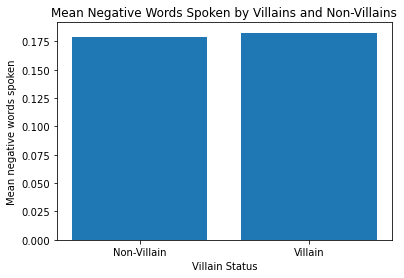

In [73]:
# Number of movies released each year in dataframe
print("Number of movies released each year in dataframe:")
local_dataframe['year'].value_counts()

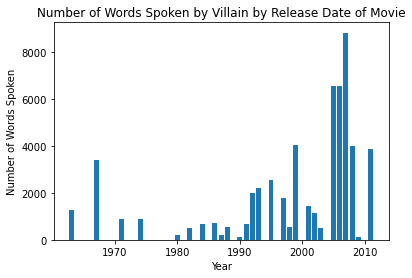

In [51]:
# Average year that the movies were released
print("Average year that the movies were released: {".format(local_dataframe['year'].mean()))


# Mean negative words by Villain versus Non-Villain
labels = ['Non-Villain', 'Villain']
negatives_by_type=grouped['mean_negative'].mean()

labels = ['Non-Villain', 'Villain']
plt.bar(labels, negatives_by_type)
plt.title('Mean Negative Words Spoken by Villains and Non-Villains')
plt.xlabel('Villain Status')
plt.ylabel('Mean negative words spoken')

plt.show()


# Number of Words Spoken by Villain by Release Date of Movie
villains = local_dataframe[local_dataframe["is_villain"] == True]
by_year=local_dataframe.groupby(['year'])
plt.bar(villains['year'], villains['num_words'])
plt.xlabel('Year')
plt.ylabel('Number of Words Spoken')
plt.title('Number of Words Spoken by Villain by Release Date of Movie')
plt.show()